In [30]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.dpi'] = 300

import warnings
warnings.filterwarnings("ignore")

In [2]:
import shap
shap.initjs()

In [3]:
data = pd.read_csv('../../data/GABAA.csv',encoding='gb18030')

# Feature extraction & Data splitting

In [4]:
featurizer = dc.feat.MACCSKeysFingerprint()
features = featurizer.featurize(data['smiles'])
#dataset = dc.data.NumpyDataset(features,data['class'])

In [5]:
from sklearn.feature_selection import VarianceThreshold


vt = VarianceThreshold(threshold = (.98 * (1 - .98)))


X_new = vt.fit_transform(features)
dataset = dc.data.NumpyDataset(X_new,data['class'])

In [6]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=400)

In [7]:
data_maccs_mask = vt.get_support(indices=True)

# t-SNE

<Axes: >

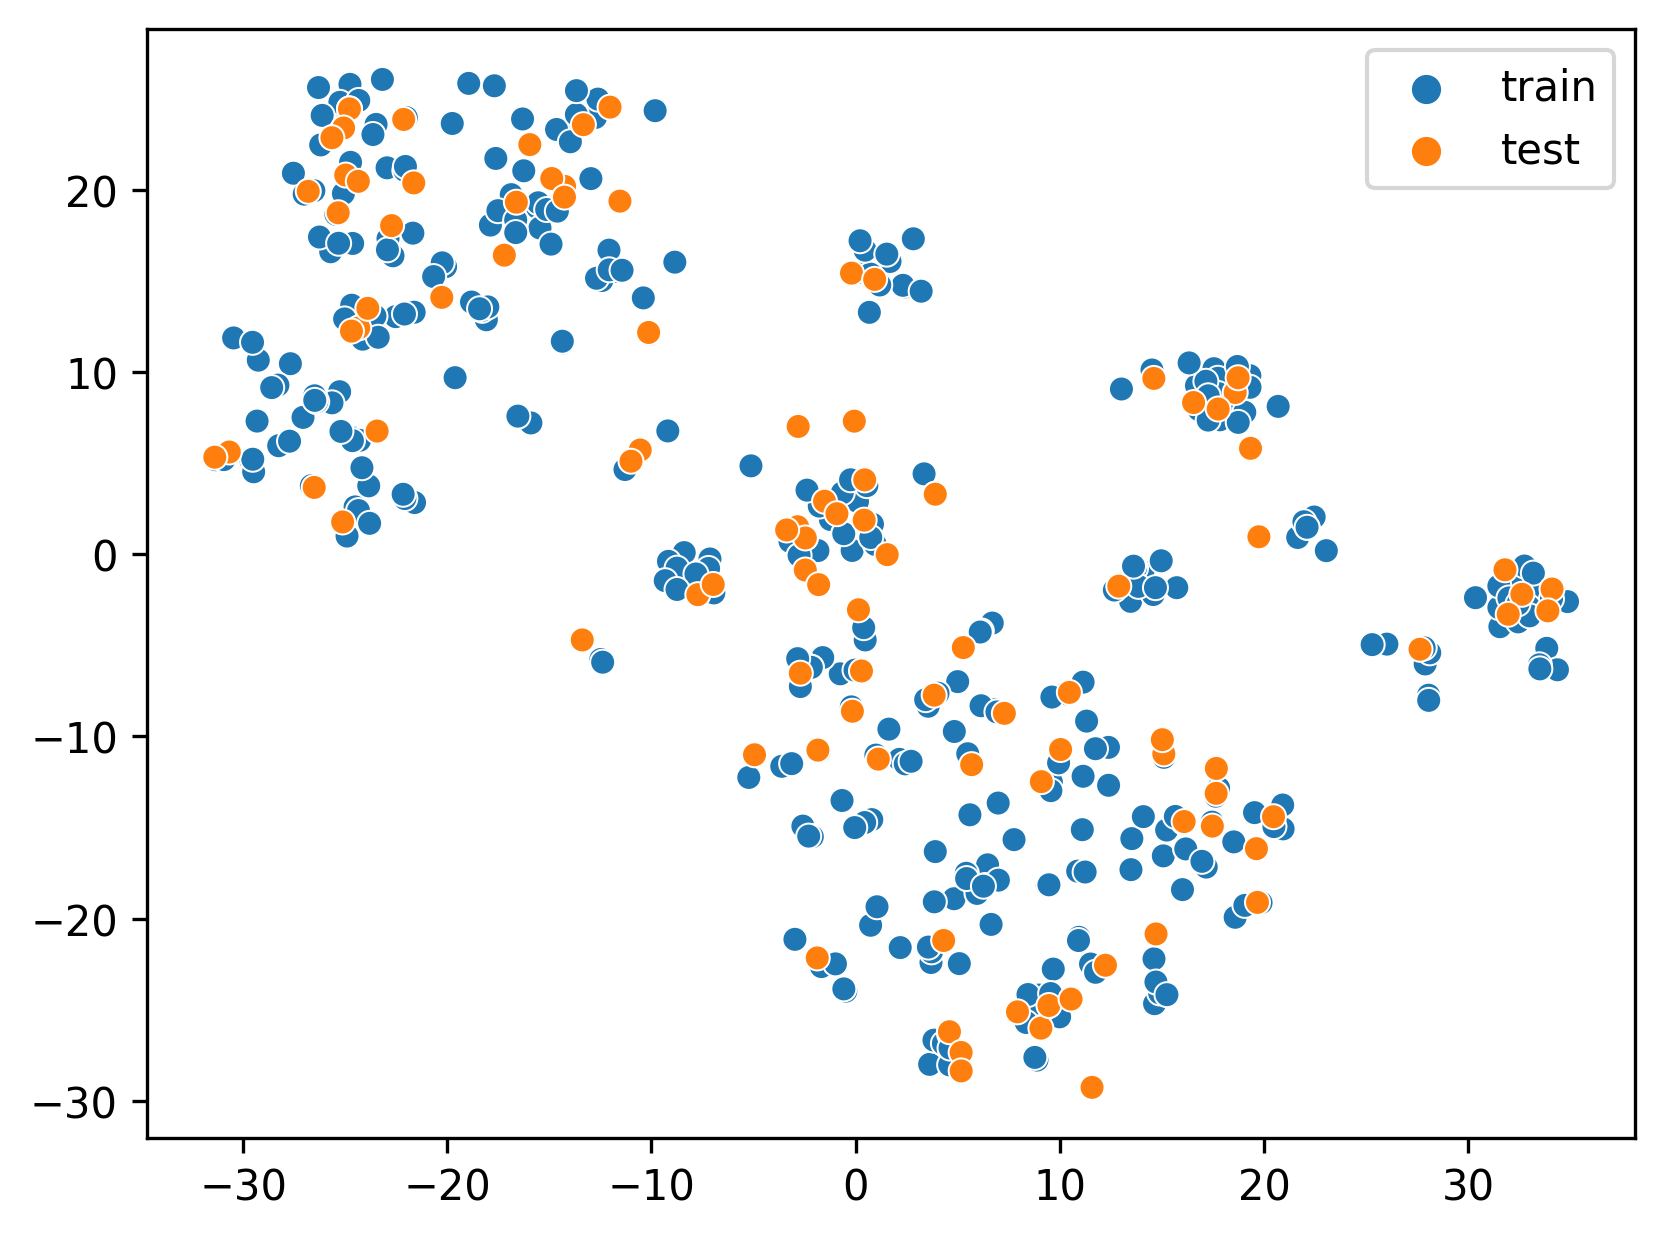

In [31]:
data_MACCSkeys = np.concatenate((train_dataset.X, test_dataset.X), axis=0)


tsne = TSNE(n_components=2,random_state=42)
transformed_data = tsne.fit_transform(data_MACCSkeys)


sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1], hue=['train']*390 + ['test']*98)

# GridSearchCV

In [8]:
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
}


param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100], 
              'kernel': ['linear', 'rbf','poly'],
             'gamma':[0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.8, 0.9, 1]
             }
    
svm_classifier = SVC(probability=True)

gs = GridSearchCV(
                    svm_classifier,
                   param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=400),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

gs_fit = gs.fit(train_dataset.X, train_dataset.y.ravel())

In [9]:
val_AUC = gs.best_score_
val_ACC = gs.cv_results_['mean_test_ACC'][gs.best_index_]
val_PRE = gs.cv_results_['mean_test_PRE'][gs.best_index_]
val_REC = gs.cv_results_['mean_test_REC'][gs.best_index_]

In [10]:
print('Best parameters: ', gs.best_params_)
print('Best score (AUC): ', gs.best_score_)
print('ACC: ',gs.cv_results_['mean_test_ACC'][gs.best_index_])
print('PRE: ',gs.cv_results_['mean_test_PRE'][gs.best_index_])
print('REC: ',gs.cv_results_['mean_test_REC'][gs.best_index_])

Best parameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score (AUC):  0.9425238839628648
ACC:  0.8692307692307691
PRE:  0.8543551929258111
REC:  0.902238400661543


In [11]:
model = gs_fit.best_estimator_
model

SVC(C=1, gamma=0.1, probability=True)

# Model evaluation

In [12]:
y_test_pred_proba = model.predict_proba(test_dataset.X)
y_test_pred = model.predict(test_dataset.X)

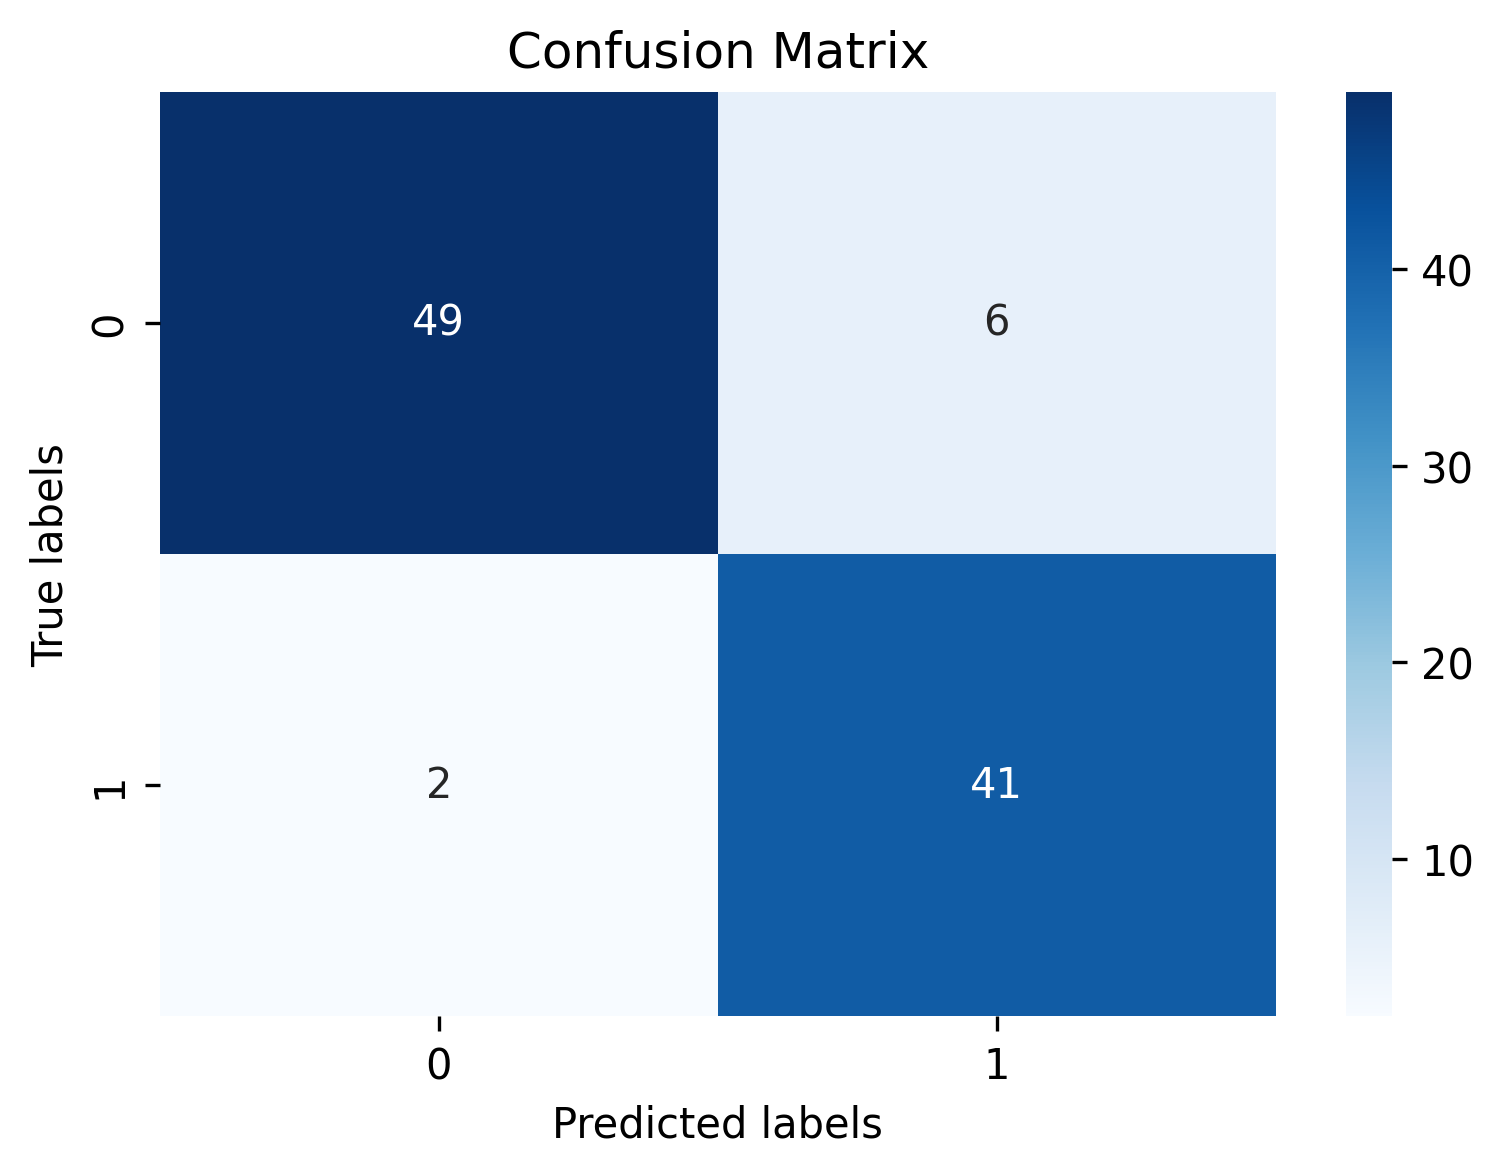

In [13]:
confusion_mat = confusion_matrix(test_dataset.y, y_test_pred)
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [14]:
test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [15]:
test_pred_array = np.array(test_pred_list)

In [16]:
test_AUC = roc_auc_score(test_dataset.y,test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(test_pred_array))

In [17]:
performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [18]:
performance = pd.DataFrame(performance_dataset,index=['val','test'])
performance

,AUC,ACC,PRE,REC
val,0.942524,0.869231,0.854355,0.902238
test,0.991966,0.928571,0.891304,0.953488


In [25]:
import pickle

with open('svm_maccs_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Ave_confusion_matrix

In [19]:
confusion_mat_ave = np.array([[41.8,5.4],[5.2,45.6]])

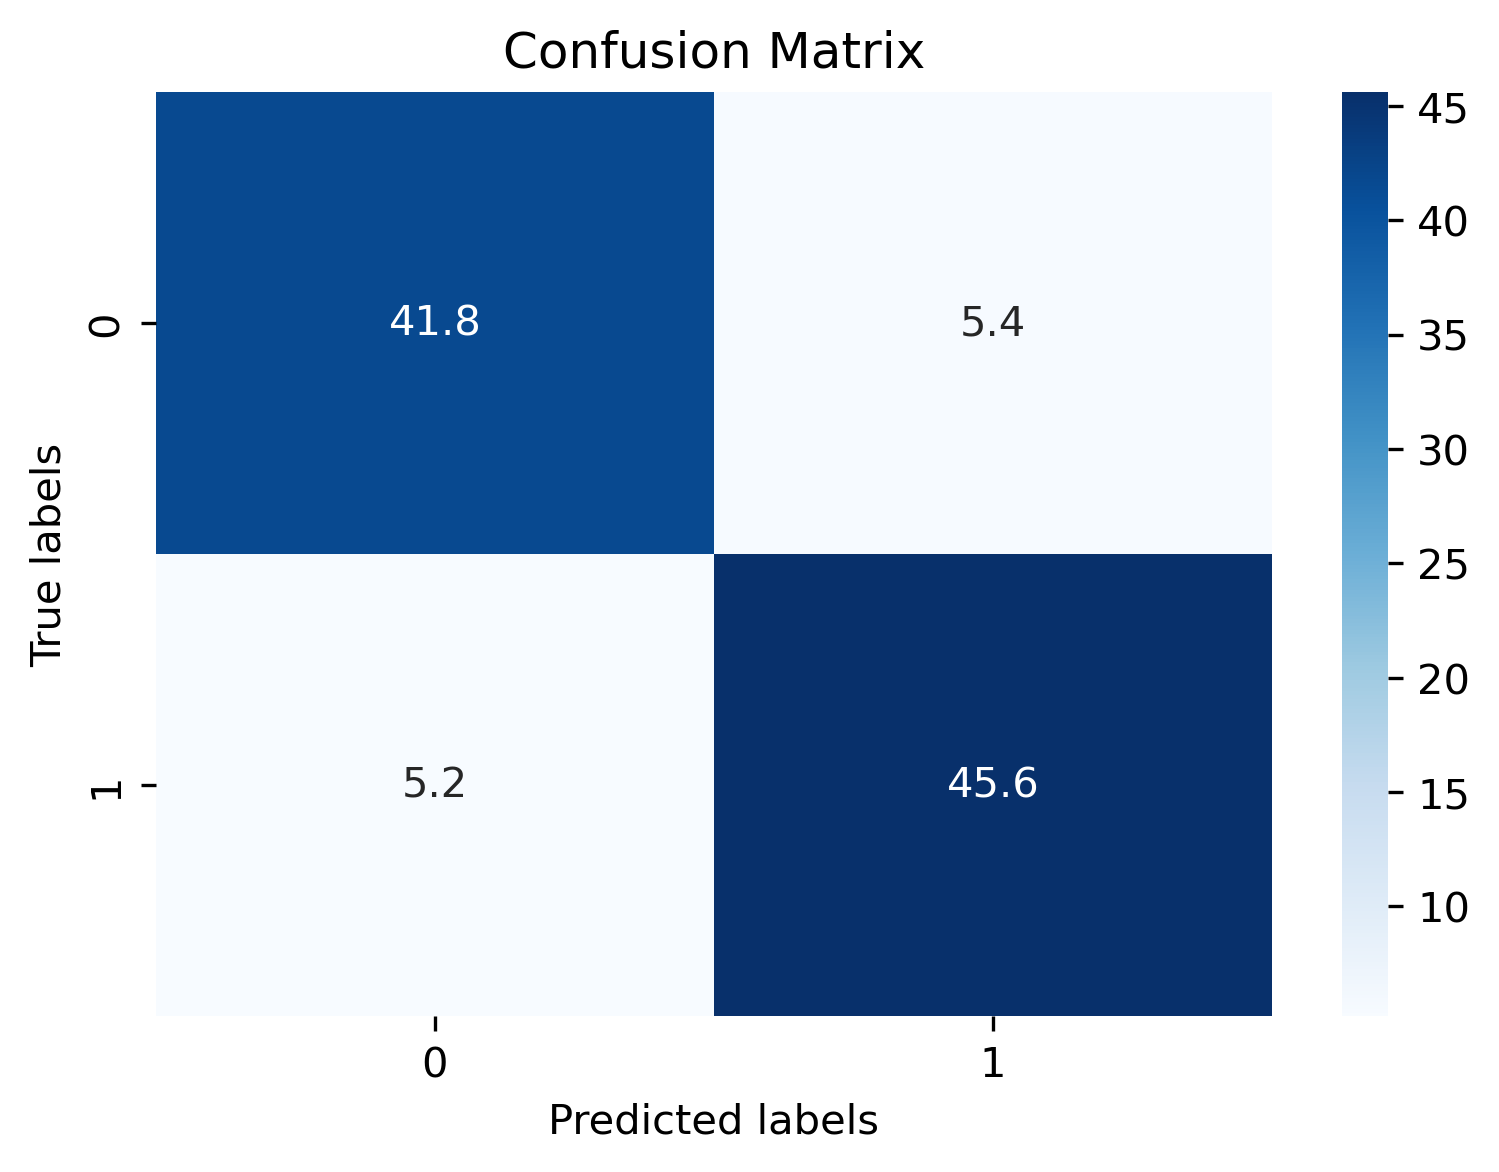

In [20]:

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_ave, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# SHAP

In [12]:
MACCS = pd.read_csv('../../data/MACCS.csv',encoding='gb18030')
result = [MACCS['REMARK'][i-1] for i in data_maccs_mask]

In [13]:
explainer = shap.KernelExplainer(model.predict,test_dataset.X,feature_names=result)

In [14]:
shap_values = explainer.shap_values(test_dataset.X)

  0%|          | 0/98 [00:00<?, ?it/s]

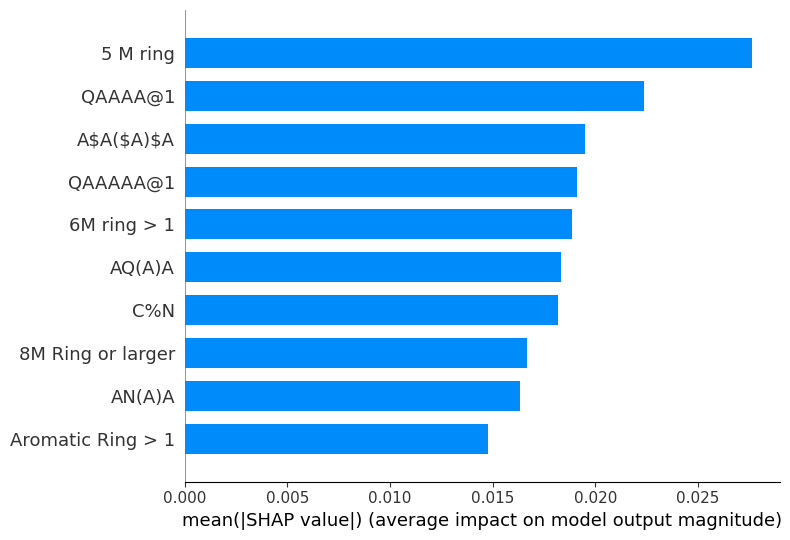

In [15]:
shap.summary_plot(shap_values, test_dataset.X, plot_type="bar", max_display=10,feature_names = result)

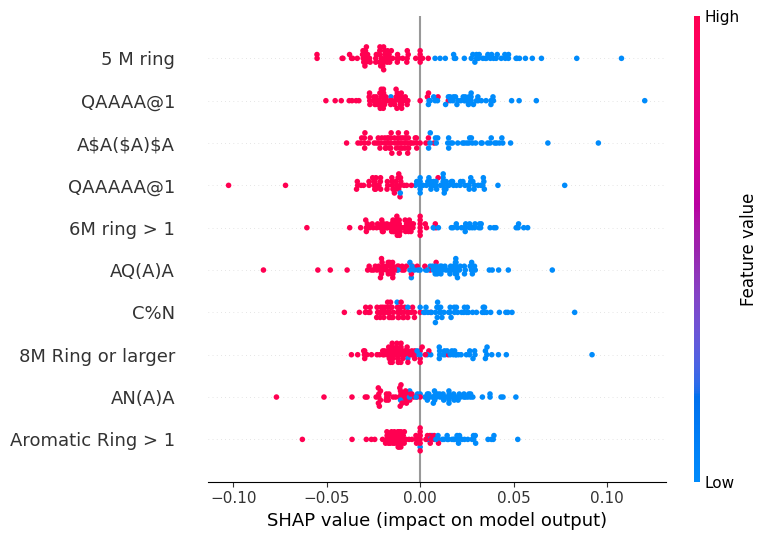

In [16]:
shap.summary_plot(shap_values, test_dataset.X,max_display=10,feature_names = result)

In [17]:
expected_value = explainer.expected_value

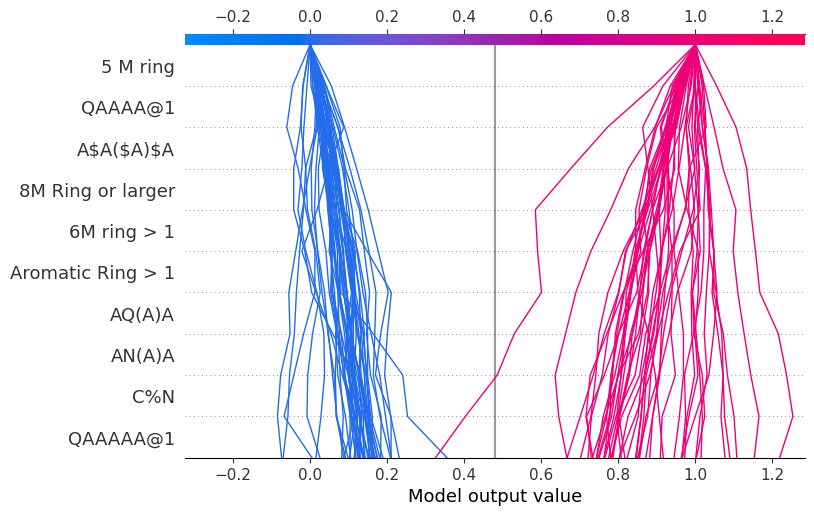

In [18]:
shap.decision_plot(expected_value, shap_values, test_dataset.X, feature_names = result,feature_order='hclust',feature_display_range=slice(None,-11,-1))

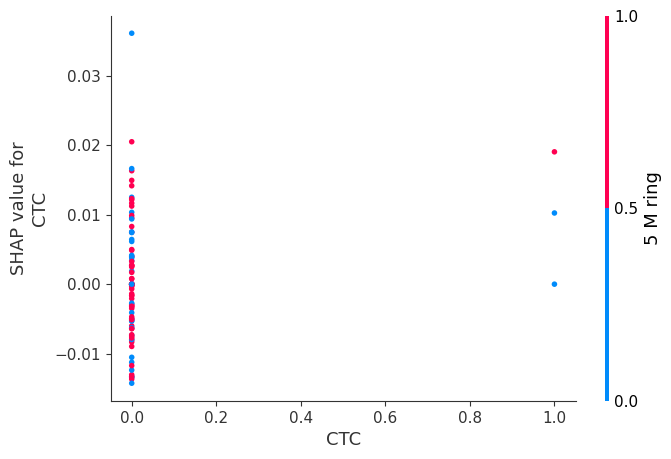

In [19]:
feature_index = 0
feature_name = result[feature_index] 

shap.dependence_plot(feature_name, shap_values, test_dataset.X, feature_names=result)

# global_force_plot

In [20]:
shap.force_plot(explainer.expected_value, shap_values,test_dataset.X,feature_names = result)

# plot_experimental_compounds

In [16]:
exp_compounds = pd.read_excel('../../data/experimental_compounds.xlsx')

In [17]:
exp_compounds_featrures = featurizer.featurize(exp_compounds['SMILES'])

In [18]:
mask = vt.get_support(indices=True)
exp_compounds_selected = exp_compounds_featrures[:, mask]

In [19]:
exp_compounds_prob = model.predict_proba(exp_compounds_selected)

In [20]:
exp_compounds_prob

array([[0.02827892, 0.97172108],
       [0.08737403, 0.91262597],
       [0.05670485, 0.94329515],
       [0.03240814, 0.96759186],
       [0.03216139, 0.96783861]])

In [21]:
explainer2 = shap.KernelExplainer(model.predict,train_dataset.X,feature_names=result)

Using 390 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [22]:
shap_values2 = explainer2(exp_compounds_selected)

  0%|          | 0/5 [00:00<?, ?it/s]

In [69]:
shap.force_plot(explainer.expected_value, shap_values2,exp_compounds_featrures,feature_names = result)

In [24]:
probabilities = exp_compounds_prob[:, 1] 

In [25]:
new_base_values = probabilities - np.sum(shap_values2.values, axis=1)

In [26]:

shap_exp = shap.Explanation(
    values=shap_values2.values, 
    base_values=new_base_values, 
    data=exp_compounds_selected, 
    feature_names=result
)

# Carvacrol

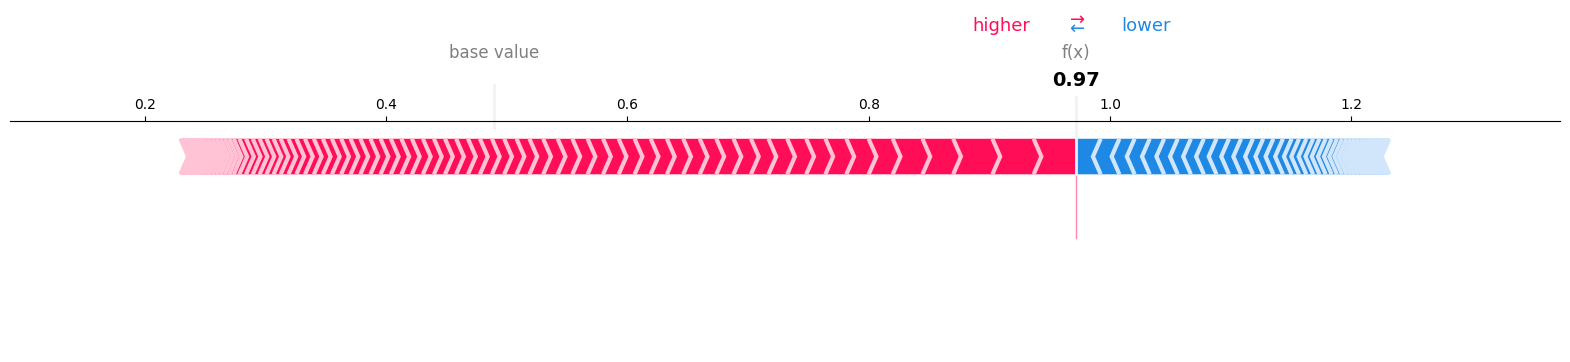

In [87]:
# sample = 0  
# shap.force_plot(
#     shap_exp.base_values[sample], 
#     shap_exp.values[sample], 
#     shap_exp.data[sample], 
#     feature_names=result,
#     matplotlib=True,
#     show=False
# )

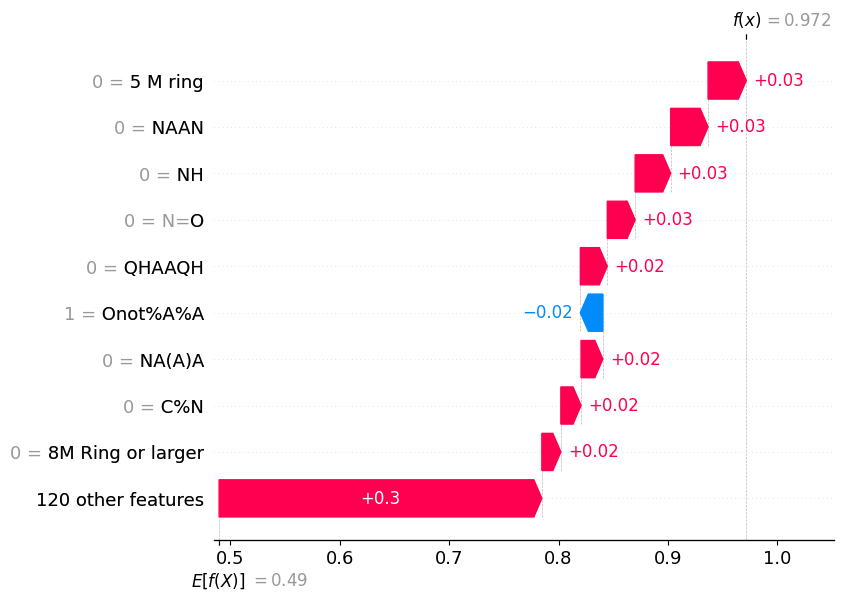

In [90]:
shap.plots.waterfall(shap_exp[0])

# Safranal

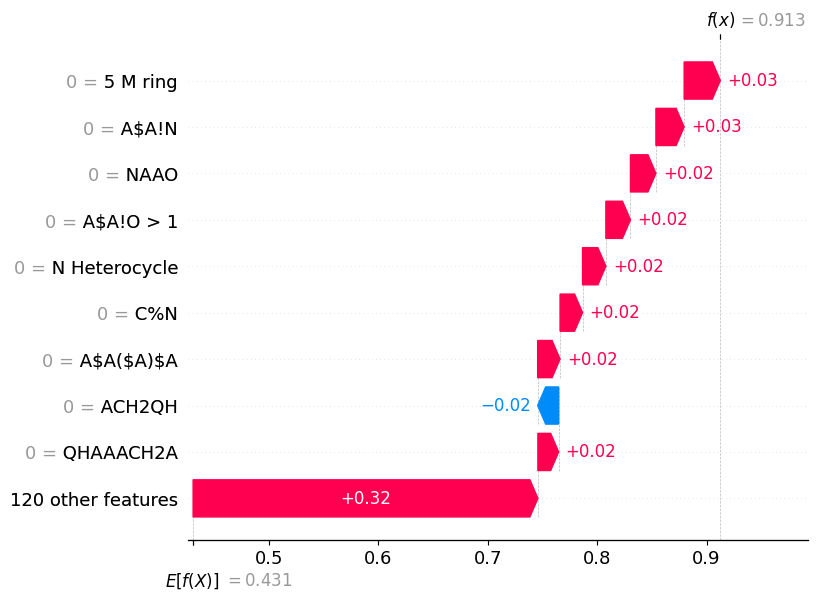

In [94]:
shap.plots.waterfall(shap_exp[1])

# Vanillin

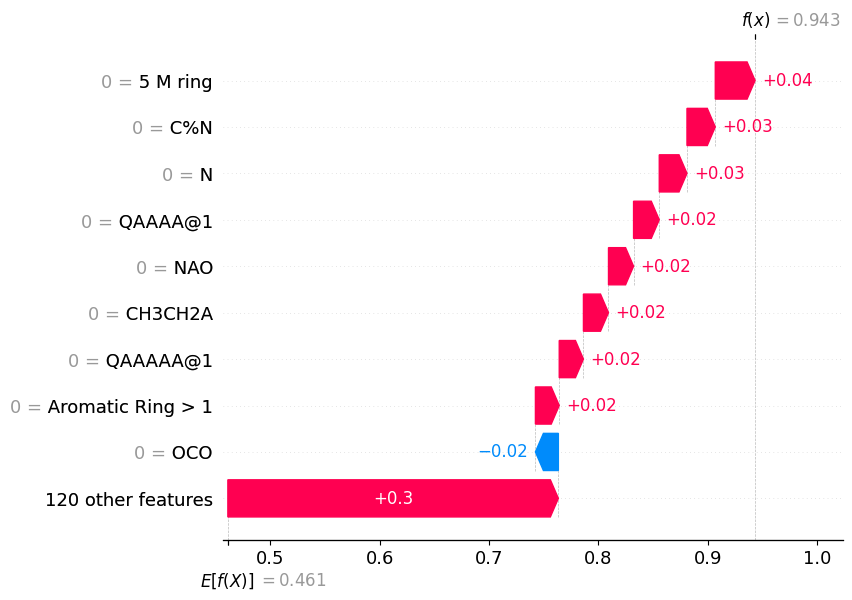

In [98]:
shap.plots.waterfall(shap_exp[2])

# Methyleugenol

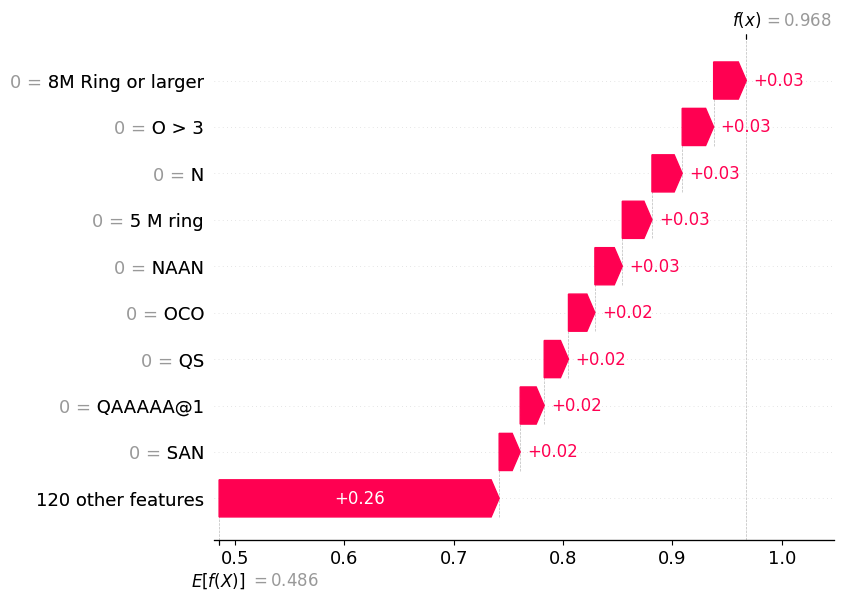

In [100]:
shap.plots.waterfall(shap_exp[3])

# Linalool

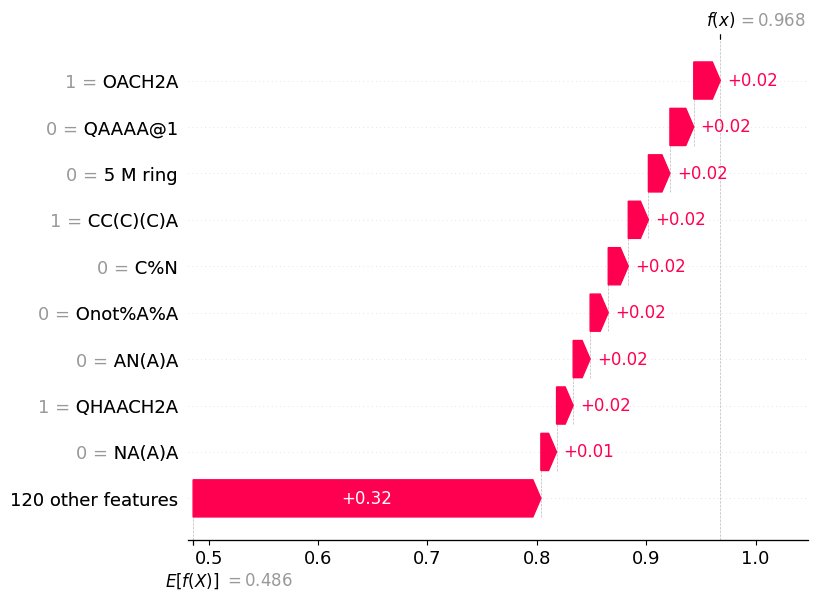

In [29]:
shap.plots.waterfall(shap_exp[4])